In [ ]:
!pip install pycountry
!pip install geopandas descartes

In [ ]:
#Import libs
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import sqlite3
import pycountry
import geopandas as gpd
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import LogNorm

In [ ]:
def plot_choropleth(df, value_column, title, legend_label):
    # Convert the Series to DataFrame for merging
    data_df = df.reset_index()
    data_df.columns = ['country_code', value_column]

    # Load a world map shapefile or GeoJSON
    world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

    # Function to convert alpha-2 country codes to alpha-3
    def convert_alpha2_to_alpha3(alpha_2_code):
        try:
            return pycountry.countries.get(alpha_2=alpha_2_code).alpha_3
        except:
            return None

    # Convert the country codes in the DataFrame
    data_df['country_code_alpha_3'] = data_df['country_code'].apply(convert_alpha2_to_alpha3)

    # Merge the world map with the DataFrame
    world = world.merge(data_df, left_on='iso_a3', right_on='country_code_alpha_3', how='left')

    # Handle zero and NaN values
    world[value_column] = world[value_column].replace(0, np.nan)  # Replace 0 with NaN
    world[value_column] = world[value_column].fillna(0)  # Now replace NaN (including former zeros) with 0 for plotting

    # Plot the map
    fig, ax = plt.subplots(1, 1, figsize=(15, 10))
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.1)

    # Define the logarithmic scale
    # We add a small value to avoid taking the log of zero
    vmin = world[value_column][world[value_column] > 0].min()
    vmax = world[value_column].max()
    norm = LogNorm(vmin=vmin, vmax=vmax)

    # Plot countries with data using logarithmic scale
    world[world[value_column] > 0].plot(column=value_column, ax=ax, legend=True, cax=cax, cmap='RdYlGn',
                                         legend_kwds={'label': legend_label},
                                         norm=norm)

    # Plot countries with no data or zero values in gray
    world[world[value_column] == 0].plot(ax=ax, color='gray')

    # Remove axis
    ax.set_axis_off()

    # Set a title
    ax.set_title(title, fontdict={'fontsize': '20', 'fontweight' : '3'})

    # Show the map
    plt.show()


In [ ]:
#Connect to GitHub for faster access
!git clone https://github.com/melihkurtaran/Clash_Royale.git

fatal: destination path 'Clash_Royale' already exists and is not an empty directory.


In [ ]:
# Connect to the SQLite database file
connection = sqlite3.connect('Clash_Royale/sample.sqlite')  # Replace with your database file path
cursor = connection.cursor()

# Run the SQL Query to get table names
cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")

# Fetch all the table names
table_names = cursor.fetchall()

# Print the table names
for table in table_names:
    print(table[0])

# Close the cursor and connection
cursor.close()
connection.close()

account
iap_purchase
account_date_session


In [ ]:
import sqlite3
import pandas as pd

# Connect to the SQLite database file
connection = sqlite3.connect('Clash_Royale/sample.sqlite')

# Get table names
cursor = connection.cursor()
cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
table_names = cursor.fetchall()
cursor.close()

# Create dataframes for each table
dataframes = {}
for table in table_names:
    table_name = table[0]
    query = f"SELECT * FROM {table_name};"
    dataframe = pd.read_sql_query(query, connection)
    dataframes[table_name] = dataframe

# Close the connection
connection.close()

In [ ]:
df_account = dataframes['account']
df_iap_purchase = dataframes['iap_purchase']
df_account_date_session = dataframes['account_date_session']

# Average revenue per user per market

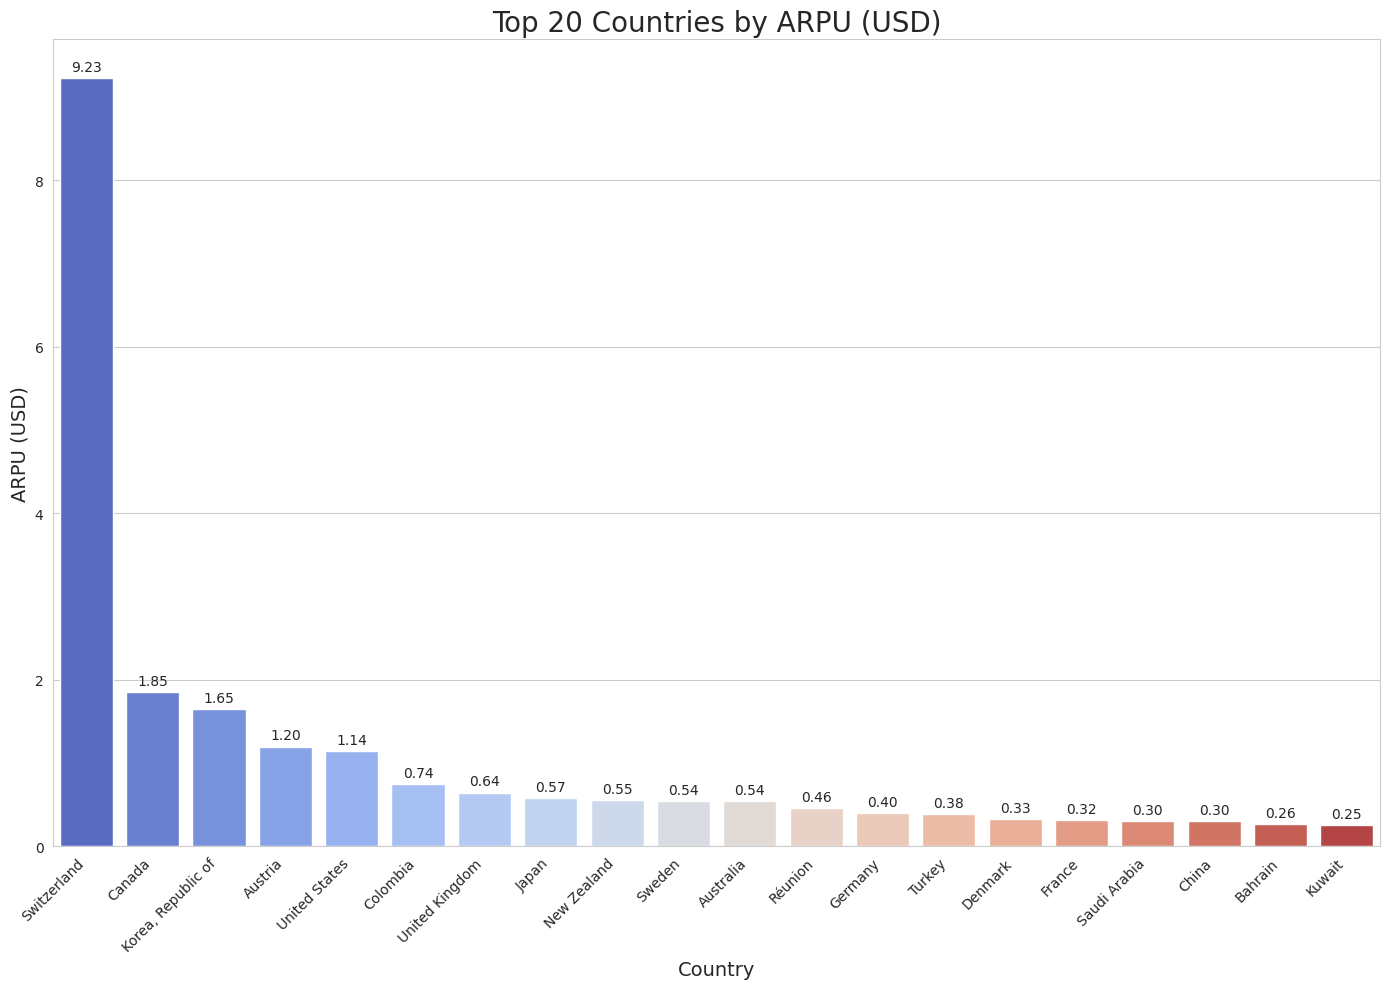

In [ ]:
# Merge the two dataframes on 'account_id' with a right join to include all accounts
merged_df = pd.merge(df_iap_purchase, df_account, on='account_id', how='right', suffixes=('_purchase', '_account'))

# Fill NaN values in 'iap_price_usd_cents' with 0 for accounts with no purchases
merged_df['iap_price_usd_cents'].fillna(0, inplace=True)

# Group by 'country_code' from the account dataframe and sum the 'iap_price_usd_cents'
country_iap_sums = merged_df.groupby('country_code')['iap_price_usd_cents'].sum()

# Count the total number of users per country from the account dataframe
country_user_counts = df_account['country_code'].value_counts()

# Calculate ARPU (in cents) and convert to dollars
country_arpu = (country_iap_sums / country_user_counts) / 100

# Sort the ARPU in descending order and take the top 20
top_countries_arpu = country_arpu.sort_values(ascending=False).head(20)

# Convert two-letter country codes to country names using pycountry
def get_country_name(country_code):
    try:
        return pycountry.countries.get(alpha_2=country_code).name
    except:
        return "Unknown"

# Apply the conversion to the index
top_countries_arpu.index = top_countries_arpu.index.map(get_country_name)

# Plotting the bar chart with seaborn for a better look and feel
plt.figure(figsize=(14, 10))  # Adjust the figure size as needed
sns.set_style("whitegrid")  # Set the style of the visualization

# Create a color palette to make the chart more visually appealing
palette = sns.color_palette("coolwarm", len(top_countries_arpu))

# Plot the bar chart with the new palette
bars = sns.barplot(x=top_countries_arpu.index, y=top_countries_arpu, palette=palette)

# Add value labels on top of each bar
for bar in bars.patches:
    bars.annotate(format(bar.get_height(), '.2f'),
                  (bar.get_x() + bar.get_width() / 2,
                   bar.get_height()), ha='center', va='center',
                   size=10, xytext=(0, 8),
                   textcoords='offset points')

# Set the title and labels with a font size that's readable
plt.title('Top 20 Countries by ARPU (USD)', fontsize=20)
plt.xlabel('Country', fontsize=14)
plt.ylabel('ARPU (USD)', fontsize=14)

# Rotate the x-axis labels for better readability
plt.xticks(rotation=45, ha='right')

# Show the plot
plt.tight_layout()  # Adjust the layout to fit the labels
plt.show()


<ipython-input-29-ad4c38132447>:7: FutureWarning:

The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.



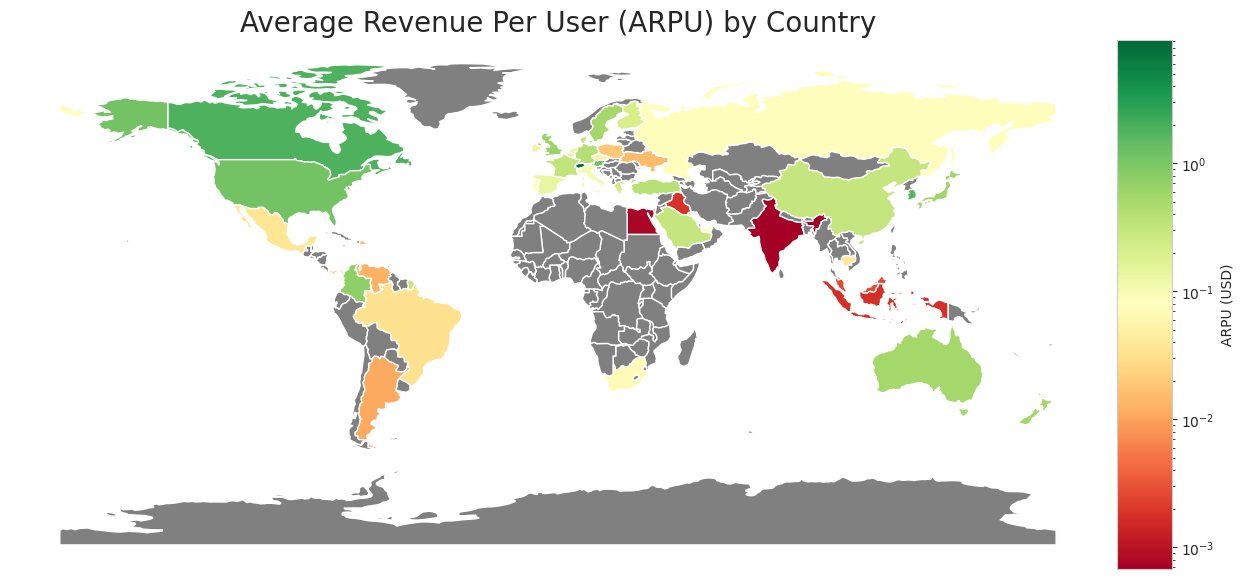

In [ ]:
plot_choropleth(country_arpu, 'ARPU', 'Average Revenue Per User (ARPU) by Country', 'ARPU (USD)')

In [ ]:
country_arpu['IN']

0.0006767193821257815

# Users who spent the most

Aggregate User Activity

In [ ]:
user_sessions_agg = df_account_date_session.groupby('account_id').agg({
    'session_count': 'sum',
    'session_duration_sec': 'sum'
}).reset_index()

Aggregate User Purchases

In [ ]:
user_iap_agg = df_iap_purchase.groupby('account_id').agg({
    'iap_price_usd_cents': 'sum'
}).reset_index()

Correlation

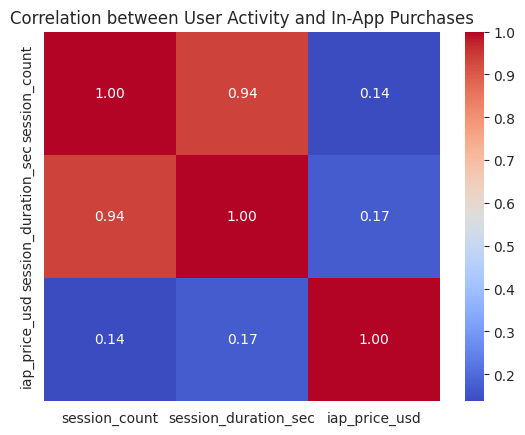

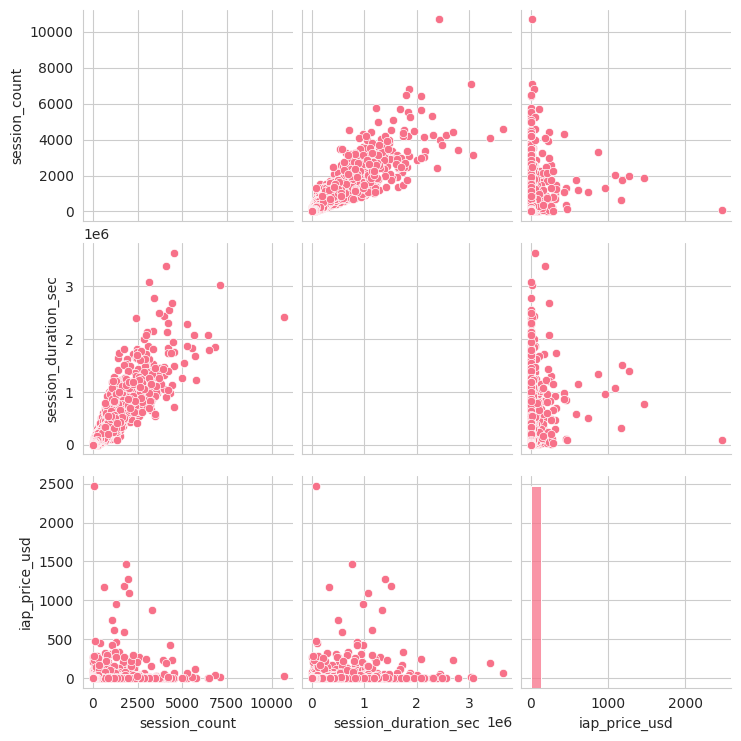

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Heatmap of the correlation matrix
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Correlation between User Activity and In-App Purchases')
plt.show()

# Pairplot to visualize the relationships
sns.pairplot(user_data_merged[['session_count', 'session_duration_sec', 'iap_price_usd']])
plt.show()


In [ ]:
df_merged = pd.merge(df_account, df_iap_purchase, on='account_id', how='left', suffixes=('_account', '_iap'))
df_merged = df_merged.groupby('account_id').agg({
    'iap_price_usd_cents': 'sum',
    'app_store_id': 'first',
    'package_id_hash': 'first',
    'created_time_iap': 'first',
    'created_device': 'first',
    'created_platform': 'first',
    'country_code': 'first',
    'created_app_store_id': 'first'
}).reset_index()

# merge the resulting dataframe with df_account_date_session on 'account_id'
df_merged = pd.merge(df_merged, df_account_date_session, on='account_id', how='left')

# Fill NaN values for 'iap_price_usd_cents' with 0 (assuming NaN means no purchase was made)
df_merged['iap_price_usd_cents'].fillna(0, inplace=True)
df_merged
# Now df_merged contains all the information from the three dataframes
# You can now perform statistical analysis on df_merged to find out which factors impact IAP purchases

# For example, you can calculate the total IAP amount per user and see how it correlates with session count and duration
df_user_iap = df_merged.groupby('account_id').agg({
    'iap_price_usd_cents': 'first',
    'session_count': 'sum',
    'session_duration_sec': 'sum',
    # Include other features from df_account that you want to analyze
    'created_device': 'first',  # Assuming the device doesn't change often
    'created_platform': 'first',
    'country_code': 'first',
    'created_app_store_id': 'first'
}).reset_index()

# Now df_user_iap contains the total IAP amount, total session count, total session duration, and other account details for each user
df_user_iap

,account_id,iap_price_usd_cents,session_count,session_duration_sec,created_device,created_platform,country_code,created_app_store_id
0,12314866,0.0,11.0,3908.0,3G 7271-HD70,Android,IN,2
1,12315420,0.0,31.0,19102.0,SM-A7000,Android,CN,4
2,12315974,0.0,1.0,151.0,GT-N7100,Android,MX,2
3,12316528,0.0,383.0,162666.0,SM-T530NU,Android,US,2
4,12317082,0.0,1.0,234.0,CHM-TL00,Android,CN,4
...,...,...,...,...,...,...,...,...
112787,8606630747,0.0,1.0,30.0,SM-T210,Android,UA,2
112788,8606631666,0.0,1.0,209.0,M-PPAG550,Android,IT,2
112789,8606632585,0.0,1.0,81.0,SM-G935V,Android,US,2
112790,8606633504,0.0,1.0,50.0,SM-G530M,Android,AR,2


In [ ]:
# Convert iap_price_usd_cents to dollars for better readability if needed
df_user_iap['iap_price_usd'] = df_user_iap['iap_price_usd_cents'] / 100

# Sort the DataFrame by 'iap_price_usd' in descending order
top_spenders = df_user_iap.sort_values(by='iap_price_usd', ascending=False)

# Take the top 10
top_spenders.head(10)

,account_id,iap_price_usd_cents,session_count,session_duration_sec,created_device,created_platform,country_code,created_app_store_id,iap_price_usd
666,12688700,247076.0,56.0,83051.0,IM-A870S,Android,KR,2,2470.76
56490,42963650136,146800.0,1855.0,775412.0,SM-G900V,Android,US,2,1468.00
77482,51553777591,126911.0,1979.0,1393427.0,"iPhone8,2",iOS,CN,1,1269.11
66552,47256657572,118687.0,1739.0,1501285.0,"iPhone8,1",iOS,US,1,1186.87
40322,34371919621,116518.0,614.0,319401.0,"iPhone7,1",iOS,CH,1,1165.18
104088,68733716584,108841.0,2015.0,1072059.0,LG-H815,Android,TR,2,1088.41
106478,8602184916,95742.0,1289.0,967398.0,SM-S820L,Android,US,2,957.42
73933,51551461440,87665.0,3287.0,1332993.0,"iPad6,8",iOS,CN,1,876.65
46544,38666650755,74272.0,1068.0,499476.0,"iPhone8,2",iOS,US,1,742.72
80203,55846221010,61512.0,1211.0,1146134.0,SM-T810,Android,US,2,615.12


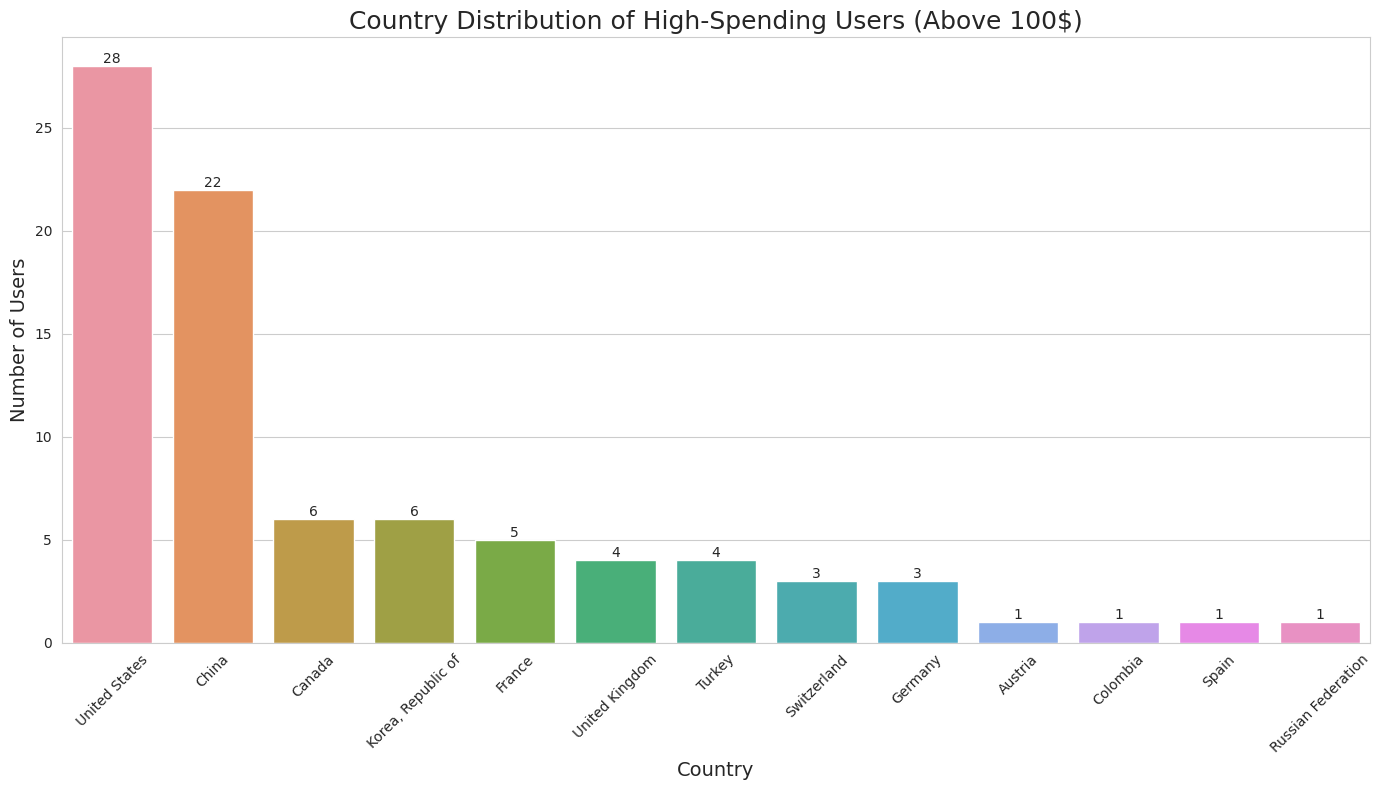

In [ ]:
# Convert 'iap_price_usd_cents' to dollars for easier filtering
df_user_iap['iap_price_usd'] = df_user_iap['iap_price_usd_cents'] / 100

# Filter the DataFrame for users who spent more than $10,000
high_spenders = df_user_iap[df_user_iap['iap_price_usd'] > 100]

# Group by 'country_code' and count the unique users
country_user_counts = high_spenders.groupby('country_code')['account_id'].nunique()

# Convert country codes to full country names
def get_country_name(country_code):
    try:
        return pycountry.countries.get(alpha_2=country_code).name
    except:
        return "Unknown"

country_user_counts.index = country_user_counts.index.map(get_country_name)

# Sort the counts in descending order
country_user_counts_sorted = country_user_counts.sort_values(ascending=False)

# Start plotting
plt.figure(figsize=(14, 8))  # Adjust the size as needed

# Use seaborn's color palette for the bars
sns.set_palette("husl")

# Create the bar chart
sns.barplot(x=country_user_counts_sorted.index, y=country_user_counts_sorted.values)

# Add labels and title
plt.title('Country Distribution of High-Spending Users (Above 100$)', fontsize=18)
plt.xlabel('Country', fontsize=14)
plt.ylabel('Number of Users', fontsize=14)

# Rotate the x-axis labels for better readability
plt.xticks(rotation=45)

# Add value labels on top of each bar
for index, value in enumerate(country_user_counts_sorted.values):
    plt.text(index, value, f'{value}', ha='center', va='bottom', fontsize=10)

# Show the plot
plt.tight_layout()  # Adjust the layout to fit the labels
plt.show()


# Money over time

In [ ]:
df_iap_purchase

,account_id,package_id_hash,iap_price_usd_cents,app_store_id
created_time,,,,
2016-03-26 23:59:59.355,30077202816,ae0253c27c34edd1ab4fe21d6bfc91f8,739,0
2016-05-31 11:24:37.283,30077202816,dd4c1bda4f2c904075fb2fbfcf30f30e,369,0
2016-02-13 03:40:28.644,21487283560,99a9e0e63efa2fdce8fc8de74c66cea9,184,0
2016-02-28 00:53:26.678,21487152816,99a9e0e63efa2fdce8fc8de74c66cea9,184,0
2016-02-11 01:03:04.727,8602037685,99a9e0e63efa2fdce8fc8de74c66cea9,184,0
...,...,...,...,...
2016-07-23 03:25:58.870,51552698769,99a9e0e63efa2fdce8fc8de74c66cea9,184,1
2016-07-25 05:57:33.827,51552698769,99a9e0e63efa2fdce8fc8de74c66cea9,184,1
2016-11-14 01:01:11.202,51552698769,efd2eebfdc98b55f9e6b45915d56f7ac,36,1


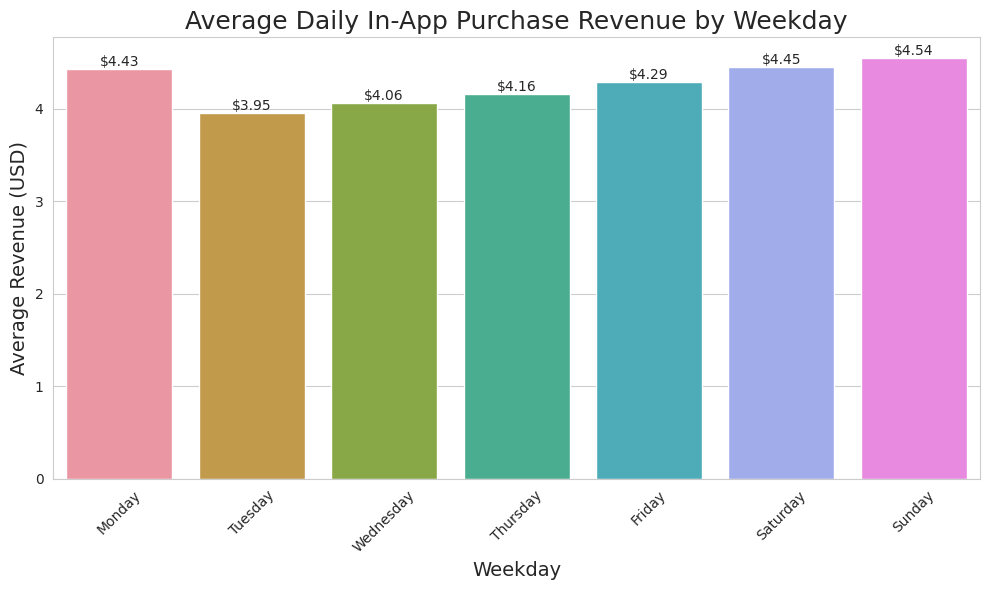

In [ ]:
# Convert 'created_time' to datetime if it's not already
df_iap_purchase['created_time'] = pd.to_datetime(df_iap_purchase['created_time'])

# Extract the day of the week from 'created_time' and create a new column 'weekday'
# The day of the week with Monday=0, Sunday=6
df_iap_purchase['weekday'] = df_iap_purchase['created_time'].dt.dayofweek

# Map the integers to actual day names for better readability
days = {0: 'Monday', 1: 'Tuesday', 2: 'Wednesday', 3: 'Thursday', 4: 'Friday', 5: 'Saturday', 6: 'Sunday'}
df_iap_purchase['weekday_name'] = df_iap_purchase['weekday'].map(days)

# Group by 'weekday_name' and sum the 'iap_price_usd_cents', then average it by the number of each weekday in the data
weekly_revenue = df_iap_purchase.groupby('weekday_name')['iap_price_usd_cents'].sum() / df_iap_purchase['weekday_name'].value_counts()

# Convert cents to dollars
weekly_revenue = weekly_revenue / 100

# Sort the days by the order of the week
weekly_revenue = weekly_revenue.loc[days.values()]

# Plotting the weekly revenue
plt.figure(figsize=(10, 6))  # Adjust the size as needed

# Use seaborn's color palette for the bars
sns.set_palette("husl")

# Create the bar chart
sns.barplot(x=weekly_revenue.index, y=weekly_revenue.values)

# Add labels and title
plt.title('Average Daily In-App Purchase Revenue by Weekday', fontsize=18)
plt.xlabel('Weekday', fontsize=14)
plt.ylabel('Average Revenue (USD)', fontsize=14)

# Rotate the x-axis labels for better readability
plt.xticks(rotation=45)

# Add value labels on top of each bar
for index, value in enumerate(weekly_revenue.values):
    plt.text(index, value, f'${value:.2f}', ha='center', va='bottom', fontsize=10)

# Show the plot
plt.tight_layout()  # Adjust the layout to fit the labels
plt.show()


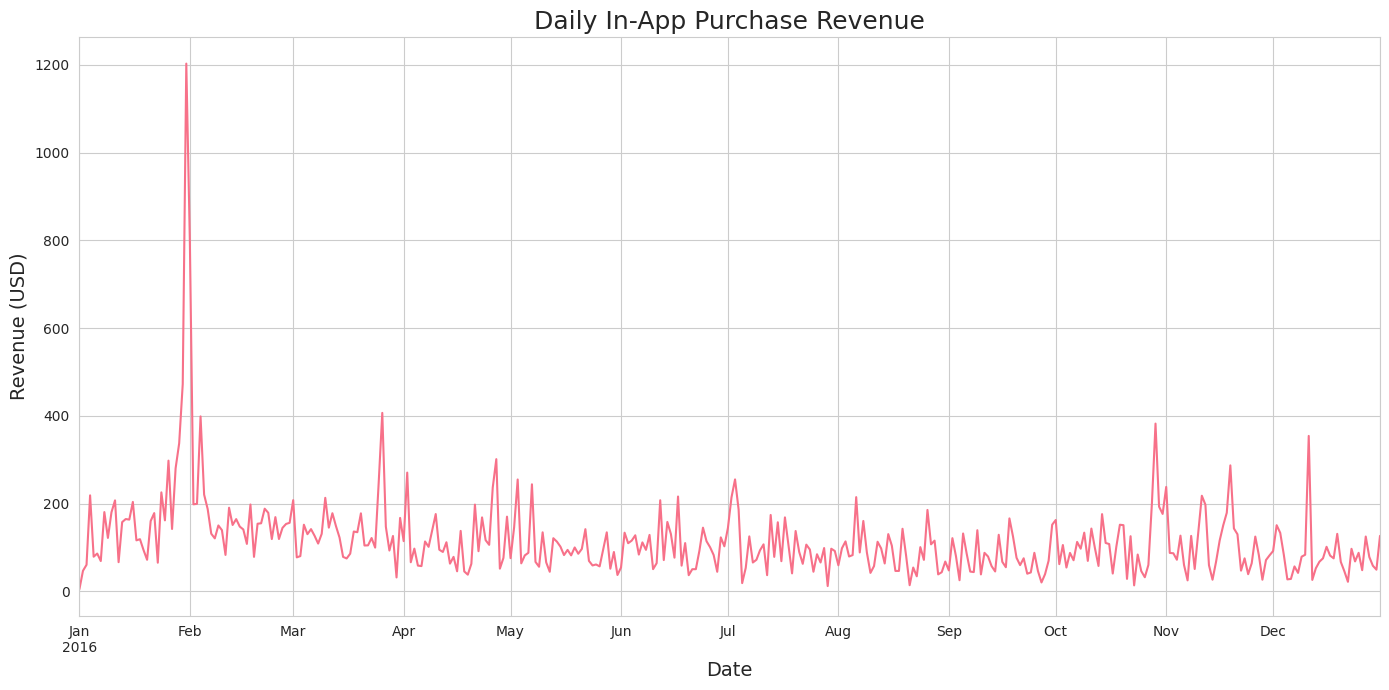

In [ ]:
# Convert 'created_time' to datetime
df_iap_purchase['created_time'] = pd.to_datetime(df_iap_purchase['created_time'])

# Set 'created_time' as the index
df_iap_purchase.set_index('created_time', inplace=True)

# Resample to daily frequency, summing up the 'iap_price_usd_cents'
daily_revenue = df_iap_purchase['iap_price_usd_cents'].resample('D').sum()

# Convert cents to dollars
daily_revenue = daily_revenue / 100

# Plotting the daily revenue
plt.figure(figsize=(14, 7))  # Adjust the size as needed
daily_revenue.plot()

# Add labels and title
plt.title('Daily In-App Purchase Revenue', fontsize=18)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Revenue (USD)', fontsize=14)

# Show the plot
plt.grid(True)
plt.tight_layout()  # Adjust the layout to fit the labels
plt.show()


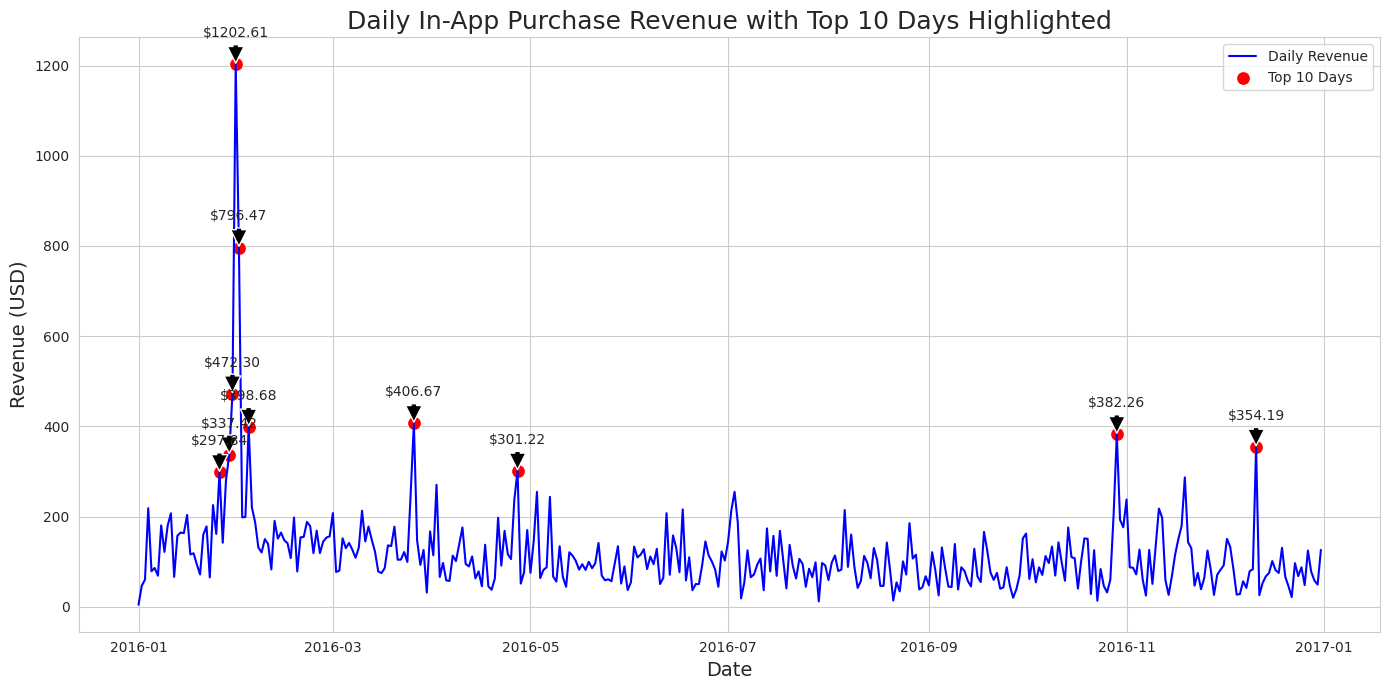

In [ ]:
# Resample to daily frequency, summing up the 'iap_price_usd_cents'
daily_revenue = df_iap_purchase['iap_price_usd_cents'].resample('D').sum()

# Convert cents to dollars
daily_revenue = daily_revenue / 100

# Find the top 10 days with the highest revenue
top_days = daily_revenue.nlargest(10)

# Start plotting
plt.figure(figsize=(14, 7))

# Plot all days with a basic color
sns.lineplot(data=daily_revenue, color='blue', label='Daily Revenue')

# Highlight the top 10 days with a brighter color
sns.scatterplot(x=top_days.index, y=top_days.values, color='red', s=100, label='Top 10 Days')

# Annotate the top 10 days
for day in top_days.index:
    plt.annotate(f'${daily_revenue[day]:.2f}',
                 xy=(day, daily_revenue[day]),
                 xytext=(day, daily_revenue[day] + daily_revenue.max()*0.05),
                 arrowprops=dict(facecolor='black', shrink=0.05),
                 ha='center')

# Add labels and title
plt.title('Daily In-App Purchase Revenue with Top 10 Days Highlighted', fontsize=18)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Revenue (USD)', fontsize=14)

# Show the legend
plt.legend()

# Show the plot with a grid
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
# Resample to daily frequency, summing up the 'iap_price_usd_cents'
daily_revenue = df_iap_purchase['iap_price_usd_cents'].resample('D').sum()

# Convert cents to dollars
daily_revenue = daily_revenue / 100

# Find the top day with the highest revenue
top_day = daily_revenue.idxmax()

# Filter the original DataFrame for the top day
top_day_purchases = df_iap_purchase[df_iap_purchase.index.date == top_day.date()]

# Reset the index to turn 'created_time' back into a column
top_day_purchases.reset_index(inplace=True)

# Display the purchases on the top day in DataFrame format
top_day_purchases


,created_time,account_id,package_id_hash,iap_price_usd_cents,app_store_id,weekday,weekday_name,day_of_week,iap_price_usd
0,2016-01-31 21:11:09.852,30077202816,ae0253c27c34edd1ab4fe21d6bfc91f8,739,0,6,Sunday,Sunday,7.39
1,2016-01-31 21:45:53.605,30077202816,99a9e0e63efa2fdce8fc8de74c66cea9,184,0,6,Sunday,Sunday,1.84
2,2016-01-31 20:18:34.052,38666770116,ae0253c27c34edd1ab4fe21d6bfc91f8,739,0,6,Sunday,Sunday,7.39
3,2016-01-31 10:56:40.757,12438367,ae0253c27c34edd1ab4fe21d6bfc91f8,739,0,6,Sunday,Sunday,7.39
4,2016-01-31 13:17:31.708,12438367,dd4c1bda4f2c904075fb2fbfcf30f30e,369,0,6,Sunday,Sunday,3.69
...,...,...,...,...,...,...,...,...,...
58,2016-01-31 11:33:18.481,51551415891,dd4c1bda4f2c904075fb2fbfcf30f30e,369,0,6,Sunday,Sunday,3.69
59,2016-01-31 08:30:34.895,34372276890,efd2eebfdc98b55f9e6b45915d56f7ac,36,0,6,Sunday,Sunday,0.36
60,2016-01-31 20:03:43.852,38667065580,dd4c1bda4f2c904075fb2fbfcf30f30e,369,0,6,Sunday,Sunday,3.69
61,2016-01-31 14:42:43.472,12384825,99a9e0e63efa2fdce8fc8de74c66cea9,184,0,6,Sunday,Sunday,1.84
